# Approximate GC simulation and Exact GC simulation

## Associted with the paper titled "Leveraging partial stragglers within gradient coding"

## Submitted to NeurIPS2024

**Instructions**

Cell **1** must be run to load all functions/packages.

Assume Cell **1** is already run.

(Optional) Cell **2** can be used to generate other random regular graphs to simulation.

To run Approximate GC Simulation, we should run Cell **3** and  **4** sequentially. It takes about 1 h 20 min to run on Google Colab (Intel(R) Xeon(R) CPU @ 2.20GHz and 13.2 GB RAM- the simulation runs on two CPUs of the same configuration).

To run Exact GC Simulation, we should run Cell **5**,  **6** and **7** sequentially. It takes about 20 min to run on Google Colab.

## Cell **1**

This cell contains all functions used in the experiment.

In [3]:
import numpy as np
import networkx as nx
import cvxpy as cp
from networkx.algorithms import bipartite
import copy
from numpy import random
import numpy.linalg
import timeit
import math
import matplotlib.pyplot as plt
import pickle
from matplotlib.ticker import MaxNLocator
from scipy import stats
import sys

# Set numpy to print output with max length
np.set_printoptions(edgeitems=30, linewidth=100000,
    formatter=dict(float=lambda x: "%.3g" % x))

# Input:
#       a 0-1 valued m by m matrix S with dtype int
# Output:
#       a X-Y bipartite graph G_S, each part has m vertices,
#       with adjacency matrix in block form:
#                                 [[0  , A]
#                                  [A.T, 0]]
def Assignment_Matrix_To_Bipartite_Graph(A):
    num_rows, num_cols = A.shape

    zeros = np.zeros((num_rows,num_rows), dtype = int)
    adjacency_matrix = np.block([[zeros, A], [A.T, zeros]]).astype(int)
    return nx.Graph(adjacency_matrix)


# Input:
#       a perfect matching M and the size of X of a X-Y bipartite graph G_S,
# Output:
#       a m by m permutation matrix P such that P_ij = 1
#       iff (X[i], Y[j]) is in M
def Matching_To_Permutation_Matrix(M, x):
    P = np.zeros((x,x), dtype = int)
    for i, (u, v) in enumerate(M.items()):
        if u < x:
            P[u,v - x] = 1
    return P


# Input:
#   A is an 0-1 valued assignment matrix whose each row and each column has equal sum
# Output:
#   Optimal ordering matrix
def ChunkOrdering(A):
    # num_rows,num_cols are size of X,Y in the X-Y bipartite graph used later,
    # We assume num_rows = num_cols.
    # Otherwise we will throw an error and return None.
    num_rows, num_cols = A.shape
    try:
        if not num_rows == num_cols:
            raise ValueError()
    except ValueError:
        print("A is not a squre matrix. Returning None")
        return None


    # We assume each row and each column sums to a same number delta.
    # Otherwise we will throw an error and return None.
    row_sum = A.sum(axis=1)
    col_sum = A.sum(axis=0)
    try:
        if not ( (row_sum == row_sum[0]).all() and (col_sum == row_sum[0]).all()):
            raise ValueError()
    except ValueError:
        print("Rows and columns do not have equal sum. Returning None")
        return None
    delta = row_sum[0]

    S = copy.copy(A)
    ordering_matrix = np.zeros((num_rows,num_rows), dtype = int)
    for i in range(delta):
        # Convert current matrix S into Bipartite graph G_S
        G_S = Assignment_Matrix_To_Bipartite_Graph(S)
        x, y = S.shape
        u = [n for n in G_S.nodes if n < x]
        # Solve max bipartite matching and convert into a permuattion matrix
        M = bipartite.maximum_matching(G_S, top_nodes=u)
        P = Matching_To_Permutation_Matrix(M, num_rows)

        # Add contribution of P into the ordering matrix and update S
        ordering_matrix = ordering_matrix + (i + 1) * P
        S = S - P

    return ordering_matrix


# Input:
#   A is an 0-1 valued assignment matrix whose each row and each column has equal sum
# Output:
#   Optimal ordering matrix
def assign_random_permutations(matrix, d):
    m = matrix.shape[0]
    result_matrix = np.zeros_like(matrix, dtype=int)

    for col in range(m):
        # Get indices of non-zero elements in the column
        non_zero_indices = np.nonzero(matrix[:, col])[0]

        # Generate a random permutation of the set {1, ..., d}
        permutation = np.random.permutation(np.arange(1, d+1))

        # Assign the permutation values to the non-zero elements
        for i, idx in enumerate(non_zero_indices):
            result_matrix[idx, col] = permutation[i]

    return result_matrix



# Input:
#   A is an 0-1 valued assignment matrix whose each row and each column has equal sum
# Output:
#   random ordering matrix
def RandomOrdering(A):
    # num_rows,num_cols are size of X,Y in the X-Y bipartite graph used later,
    # We assume num_rows = num_cols.
    # Otherwise we will throw an error and return None.
    num_rows, num_cols = A.shape
    try:
        if not num_rows == num_cols:
            raise ValueError()
    except ValueError:
        print("A is not a squre matrix. Returning None")
        return None


    # We assume each row and each column sums to a same number delta.
    # Otherwise we will throw an error and return None.
    row_sum = A.sum(axis=1)
    col_sum = A.sum(axis=0)
    try:
        if not ( (row_sum == row_sum[0]).all() and (col_sum == row_sum[0]).all()):
            raise ValueError()
    except ValueError:
        print("Rows and columns do not have equal sum. Returning None")
        return None
    delta = row_sum[0]
    ordering_matrix = copy.copy(A)


    return assign_random_permutations(ordering_matrix, delta)



# resample max_iter times and pick the ordering with best Q
def random_resample_ordering(A, k, c, delta, max_iter = 10000, print_result = False):
    #print(A)
    O = RandomOrdering(A)
    Q = calculate_max_Q(O, k, c)
    if print_result:
        print("Initial_O\n", O)
        O_print = np.flip(np.sort(O,axis = 1), axis = 1)
        O_print = O_print[::, 0:(k-c+1)]
        row_sum = O_print.sum(axis=1)
        print("Q_i of ith row for each i\n", row_sum.T)
        print("violation of Initial_O\n", calculate_violation(O, x, k, c))

    for i in range(max_iter):
        O_temp = RandomOrdering(A)
        Q_temp = calculate_max_Q(O_temp, k, c)
    if Q_temp < Q:
        O = O_temp
        Q = Q_temp


    if print_result:
        print("\nResult_O\n", O)
        O_print = np.flip(np.sort(O,axis = 1), axis = 1)
        O_print = O_print[::, 0:(k-c+1)]
        row_sum = O_print.sum(axis=1)
        print("Q_i of ith row for each i\n", row_sum.T)
    return O




# Inputs:
#     T is the time that PS waits
#     A is the assignment matrix
#     speed vector of each worker
# Output:
#     A index vector s.t. index_i = 1 if ith worker completes all jobs at time t,
#                         index_i = 0 otherwise
def original_GC_selection(A, T, speed):
    delta = A.sum(axis = 0)[0]
    index = np.where(speed * delta > T, 0, 1)
    return index




# T is the time that PS waits
# O is the ordering matrix
# speed the how fast each work does their job
# Output:
#     0-1 matrix such that B_ij = 1 if and only if the server receives the work
#                     O.W. B_ij = 0
def GC_selection_no_ordering(O, T, l, speed):
    B = np.where((O == 0) | (speed * O > T), 0, 1)
    B = np.repeat(B, l, axis=0)
    return B



# Input:
#     The B matrix indicating where are variables
#     R matrix is fixed
#     l is the parameter used to generate 1 otimes I_l
# Output:
#     A pair (x, v) such that
#     v is the minimum value of least square of B @ x - b
#     x is the argument of it.
def least_sqaure(R, B, l):
    m, n = B.shape
    all_one = np.ones(n)
    I_l = np.eye(l)
    b = np.kron(all_one, I_l)
    #print(B.shape)
    #print(b.shape)
    #print(R.shape)

    x = cp.Variable((n, m))
    #Constraint: if B_ij = 0 then X_ij = 0
    constraint = [cp.multiply(B.T, x) == x]


    #cost = cp.sum_squares(R.T @ x - b)
    cost = cp.norm(R.T @ x - b, "fro")
    prob = cp.Problem(cp.Minimize(cost), constraint)
    prob.solve()
#    if x.value is None:
#        prob.solve(verbose=True)
#        print("R.T",R.T)
#        print("B.T",B.T)
#        print("b",b)
    return (x.value, prob.value)



# Input:
#     The B matrix indicating where are variables
#     R matrix is fixed
#     l is the parameter used to generate 1 otimes I_l
# Output:
#     A pair (x, v) such that
#     v is the minimum value of least square of B @ x - b
#     x is the argument of it.
def optimized_least_sqaure(R, B, l):
    #print(R)
    m, n = B.shape
    all_one = np.ones(int(m/l))
    I_l = np.eye(l)
    b = np.kron(all_one, I_l) 
    errors = np.zeros((l,m))

    for i in range(m):
        b_ith_col = b[:,i]
        BT_ith_col = B.T[:,i]
        mask_BT_ith_col = BT_ith_col != 0
        R_i = copy.copy(R).T
        R_i = R_i[:, mask_BT_ith_col]
        _, num_var = R_i.shape 
        if num_var == 0:
            errors[:,i] = (b_ith_col)
            continue

        
        if numpy.linalg.cond(R_i.T @ R_i)< 1/sys.float_info.epsilon:
            #if l == 1:
            #    print("a")
            inv_RiTRi = numpy.linalg.inv(R_i.T @ R_i) 
            var_x = (inv_RiTRi @ R_i.T) @ b_ith_col
            errors[:,i] = (R_i @ var_x - b_ith_col)
        else: 
            var_x = numpy.linalg.pinv(R_i) @ b_ith_col 
            errors[:,i] = (R_i @ var_x - b_ith_col)


 
    return (0, numpy.linalg.norm(errors))






# Input:
#     The B matrix indicating where are variables
#     R matrix is fixed
#     l is the parameter used to generate 1 otimes I_l
# Output:
#     A pair (x, v) such that
#     v is the minimum value of least square of B @ x - b
#     x is the argument of it.
def optimized_original_least_sqaure(B, index, l):
    m, n = B.shape
    b = np.ones(m)
    R_for_org = np.ones((m, l)).reshape((m,l))
    #if l == 1:
    #    print("R.shape", R.shape)
    return optimized_least_sqaure(R_for_org, B, l)




# Input:
#     The B matrix indicating where are variables
#     R matrix is fixed
#     l is the parameter used to generate 1 otimes I_l
# Output:
#     A pair (x, v) such that
#     v is the minimum value of least square of B @ x - b
#     x is the argument of it.
def original_least_sqaure(B, index, l):
    m, n = B.shape
    b = np.ones(m)

    # Define and solve the CVXPY problem.
    x = cp.Variable(m)
    # The constraint is s.t. the irrelavant entries are set to 0
    constraint = [cp.multiply(index, x) == x]
    cost = cp.norm(B @ x - b, "fro")
    prob = cp.Problem(cp.Minimize(cost), constraint)
    prob.solve()
#    if x.value is None:
#        print("B",B)
#        print("b",b)
    return (x.value, prob.value)

# Input:
#     n number of vertices
#     d degree, must be even
# Output:
#     regular expander
def generate_random_regular_expander(n, d, max_tries=1000):
      try:
        random_regular_expander_graph = nx.random_regular_expander_graph(n, d, max_tries=1000)
        print("Successfully find the graph. Returning adjacency matrix")
        return nx.to_numpy_array(random_regular_expander_graph).astype(int)
      except nx.NetworkXError:
        print("NetworkXError. Returning None")
        return None



# Input:
#     m,l are dimension are the random matrix R
# Output:
#     A random m by What encoding routine is being used to obfuscate the domain name?l matrix R, each entry ~ Normal(0,1)
def generate_R(m, l):
    R = np.random.standard_normal(size=(m, l)).reshape((m,l))
    #if l == 1:
    #    print("R.shape", R.shape)
    return R


# Input:
#     m is the number of worker and the number of job
#     delta is the number of copies of each job
#     failure_worker is an option whether 2*delta+1 workers are forced to be fail
#     c is a number preventing 1 / A from dividing by zero error
# Output:
#     A length-m vector representing the speed of each worker.
def generate_random_speed(m, T, mu = 1, delta = 0, failure_worker = True):
    A  = np.random.exponential(scale=mu, size=m)
    #print(failure_worker)
    if failure_worker:
        failed_idx = np.random.choice(m, int(delta/2), replace = False)

        A[failed_idx] = T+1
    return A


# Calculate the estimated MSE error using inputs B and l
def calculate_l_minus_delta(B, l, print_progress = False):
    if print_progress == True:
        # m = n * l
        m, n = B.shape
        print(B.shape)
        print(B.sum(axis = 1))
        X = B.sum(axis = 1)[::2]
        print(X)
        X = l - X
        print(X)
        X = np.where(X >= 0, X, 0)
        print(X)
        print(math.sqrt(np.sum(X)))
        return math.sqrt(np.sum(X))
    else:
        m, n = B.shape
        X = B.sum(axis = 1)[::2]
        X = l - X
        X = np.where(X >= 1, X, 0)
    return math.sqrt(np.sum(X))






# Calculate which indices is such that the
# row sum of largest k-(c-1) elements are >= x
def calculate_max_Q(O, k, c):
    O = np.flip(np.sort(O,axis = 1), axis = 1)
    O = O[::, 0:(k-c+1)]
    row_sum = O.sum(axis=1)
    return np.max(row_sum)


#  This experiment performs the Approximate GC simulation.
#  Input:
#    t is the range of the time that we do experiment.
#    For example, if t = k + 1, then we will do experiment for T = 1,2...,k
#    l is the parameter indicating how many parts each chunk is divided
#    A is a m by m 0-1 valued assignment matrix with each row sum and column sum, say it is delta
#  Option:
#    num_iter is the number of experiment for each fixed T in 1,2,...,t-1
#    print_progress: If it is set to True, then it will print data in the simulation every 10 iteration
#    failure_worker: If set to true, the 2 * delta + 1 workers will never respond to the server.
#  Output:
#    Numerical experiment results.
def do_experiment(A, t, l, mu = 1, num_iter = 100, print_progress = False, failure_worker = True, time_inc = 3):
    m,n = A.shape
    delta = A.sum(axis=1)[0]
    k = A.sum(axis=0)[0]
    i = 0
    T_sequence = np.array(range(1,t,time_inc))
    length = len(range(1,t,time_inc))

    error_original = np.zeros((num_iter, length))
    error_ours = np.zeros((num_iter, length))
    error_random = np.zeros((num_iter, length))
    l_minus_delta_ours  = np.zeros((num_iter, length))
    l_minus_delta_random  = np.zeros((num_iter, length))
    Q_max_ours  = np.zeros((num_iter, length))
    Q_max_random  = np.zeros((num_iter, length))
    while i < num_iter:
        R = generate_R(m, l)
        speed = generate_random_speed(m, t, mu, delta, failure_worker)

        #if l == 1:
        #    print("R",R)

        try:
            O_random = random_resample_ordering(A, k, c=1, delta=delta, max_iter = 100)
            Q_max_random[i] = calculate_max_Q(O_random, k, l)
            O_ours = ChunkOrdering(A)
            Q_max_ours[i] = calculate_max_Q(O_ours, k, l)

            for T in range(length):
                current_T = T_sequence[T]
                if l == 1:
                    index = (original_GC_selection(A, current_T, speed))
                    x1, v1 = original_least_sqaure(A, index, l) 
                    if x1 is None:
                        continue
                    error_original[i, T] = v1

                #if l == 1:
                #    print("R_1",R)
                B2 = GC_selection_no_ordering(O_ours, current_T, l, speed)
                l_minus_delta_ours_time_T = calculate_l_minus_delta(B2, l)
                x2, v2 = optimized_least_sqaure(R, B2, l)

                B3 = GC_selection_no_ordering(O_random, current_T, l, speed)
                l_minus_delta_random_time_T = calculate_l_minus_delta(B3, l)
                x3, v3 = optimized_least_sqaure(R, B3, l)


                if x2 is None or x3 is None:
                    #print("one of x1, x2, x3 is None")
                    continue


                error_ours[i, T] = v2
                error_random[i, T] = v3
                l_minus_delta_ours[i, T] = l_minus_delta_ours_time_T
                l_minus_delta_random[i, T] = l_minus_delta_random_time_T


                if (i % 10 == 0) and print_progress:
                    print(timeit.default_timer())
                    print("\nB", A)
                    print("")
                    if l == 1:
                        print("Original error:", v1)
                    print("\nB2", B2)
                    calculate_l_minus_delta(B2, l, print_progress = True)
                    print("Ours error:", v2)
                    print("\nB3", B3)
                    calculate_l_minus_delta(B3, l, print_progress = True)
                    print("Random error:", v3)
                    print("i:", i)
                    print("\n\n")
        except ValueError as e:
            if "ECOS cannot handle sparse data with nnz == 0" in str(e):
                continue
        i += 1

    result = {}
    result["error_original"] = error_original
    result["error_ours"] = error_ours
    result["error_random"] = error_random
    result["l_minus_delta_ours"] = l_minus_delta_ours
    result["l_minus_delta_random"]= l_minus_delta_random
    result["Q_max_ours"] = Q_max_ours
    result["Q_max_random"] = Q_max_random

    return result

# function that returns a cyclic assignment matrix
def cyclic_assignment_matrix(k = 7, N=100):
    a = [1 for i in range(k)]
    for i in range(N - k):
        a.append(0)
    a = np.array(a)
    result = [a]

    for i in range(1, N):
        x = np.roll(a, i, axis=0)
        result.append(x)

    result = np.vstack(result)
    return(result.T)




#  This experiment performs the Exact GC simulation.
#  Input:
#    t is the range of the time that we do experiment.
#    For example, if t = k + 1, then we will do experiment for T = 1,2...,k
#    l is the parameter indicating how many parts each chunk is divided
#    A is a m by m 0-1 valued assignment matrix with each row sum and column sum, say it is delta
#  Option:
#    num_iter is the number of experiment for each fixed T in 1,2,...,t-1
#    print_progress: If it is set to True, then it will print data in the simulation every 10 iteration
#    failure_worker: If set to true, the 2 * delta + 1 workers will never respond to the server.
#  Output:
#    Numerical experiment results.
#    two arrays- a, b
#    a (Original GC): contains completion time for original GC
#    b (Partial GC): conatins completion time for partial GC scheme

def do_experiment2(A, t, l, mu=1, num_iter = 100, print_progress = False, failure_worker = True):
    a = []
    b = []
    c = []
    m,n = A.shape
    delta = A.sum(axis=1)[0]
    k = A.sum(axis=0)[0]

    for i in range(num_iter):
        R = generate_R(m, l)
        #print(i, "------------")
        #print("failure_worker", failure_worker)
        speed = generate_random_speed(m, mu, delta, failure_worker = failure_worker)
        #if i == 4: print(speed)
        O_random = random_resample_ordering(A, k, l, delta, max_iter = 200)
        O_ours = ChunkOrdering(A)

        for T1 in range(1,t):
            col_sums = [0 for i in range(len(A[0]))]
            #print()
            index = (original_GC_selection(A, T1, speed))
            #print(index)
            #print()
            for i in range(len(index)):
                if (index[i] == 1):
                    #print(A[:, i])
                    x = (A[:, i])
                    for j in range(len(A[0])):
                        if (x[j] == 1): col_sums[j] += 1
            #print()
            #print("col sums: ", col_sums)

            done = 0
            for i in range(len(col_sums)):
                if col_sums[i] >= l: done += 1
            #print(done)

            if (done == len(A[0])):
                #print("TIME: ", T1)
                a.append(T1)
                break


        for T2 in range(1,t):
            try:
                B2 = (GC_selection_no_ordering(O_ours, T2, l, speed))
                x2, v2 = optimized_least_sqaure(R, B2, l)
                #print(v2)
                if (v2 <= 1e-5):
                    #print("Ours: ", T2)
                    b.append(T2)
                    break

            except ValueError as e:
                if "ECOS cannot handle sparse data with nnz == 0" in str(e):
                    #print("all workers done", T2)
                    b.append(T2)
                    break

        for T3 in range(1,t):
            try:
                B3 = (GC_selection_no_ordering(O_random, T3, l , speed))
                l_minus_delta_random = calculate_l_minus_delta(B3, l)
                x3, v3 = optimized_least_sqaure(R, B3, l)

                if (v3 <= 1e-5):
                    #print("Ours: ", T2)
                    c.append(T3)
                    break

            except ValueError as e:
                if "ECOS cannot handle sparse data with nnz == 0" in str(e):
                    #print("all workers done", T2)
                    c.append(T3)
                    break
    return a, b, c




# Calculate 96% confidence interval for the errorbar
def find_interval(errors, l = 0.02, h = 0.98):
    m, n = errors.shape
    #print(stats.normaltest(errors, axis = 1))
    sorted_err = np.sort(errors, axis=0)
    mean = np.mean(sorted_err, axis = 0)
    std = np.std(sorted_err, axis = 0)
    low = np.zeros(n)
    high = np.zeros(n) 
    for i in range(n):
        high[i] = std[i]
        if mean[i] > std[i]:
            low[i] = std[i]
        else:
            low[i] = mean[i] - 1e-14 
    print("mean", mean)
    print("std", std)
    print("low_CI", mean - sorted_err[int(l * m), :])
    print("high_CI", sorted_err[int(h * m), :] - mean) 

    return np.vstack((low, high))



# Plot the result for Partial GC vs Original GC
def plot_result_ours_orig(data, name = ""):
    #print(data["adj_mtx"].shape)
    #print(data["l = 1"]) 
    #result["error_original"] = error_original 
    #result["error_ours"] = error_ours
    #result["error_random"] = error_random
    #result["l_minus_delta_ours"] = l_minus_delta_ours
    #result["l_minus_delta_random"]= l_minus_delta_random
    
    l_1 = data["l = 1"]
    #print(l_1["error_original"])
    l_2 = data["l = 2"]
    l_3 = data["l = 3"]
    _, t = l_1["error_original"].shape
    T = np.array(range(1,t+1)) * 3
    
    # Prepare the plot
    plt.figure(figsize=(12, 8))

    # Colors and markers for differentiation
    colors = ['b', 'g', 'r', 'm', 'k', 'y', 'c']
    markers = ['o', 's', 'D', '^', 'p']
    lines = ['-', '--', '-.', '--', ':'] 
    error_types = ['error_ours', 'error_random', 'error_original', 'l_minus_delta_ours', 'l_minus_delta_random']
    type_legend = {'error_ours': 'Partial GC', 'error_original': 'Orig. GC', 'l_minus_delta_ours': 'Partial GC Est.'}
    

    errors_l_1_org_err = np.array(l_1["error_original"])
    means_l_1_org_err = np.mean(errors_l_1_org_err, axis=0)
    interval_l_1_org_err = find_interval(errors_l_1_org_err)
    print("T", T)
    print("means_l_1_org_err", means_l_1_org_err)
    plt.errorbar(T, means_l_1_org_err, yerr=interval_l_1_org_err, label=f'{type_legend["error_original"]}', linestyle="-.",
                 linewidth=3,color=colors[2], marker=markers[0], markersize=10, capsize = 8, capthick = 3)
    
    errors_l_1_ours_err = np.array(l_1["error_ours"])
    means_l_1_ours_err = np.mean(errors_l_1_ours_err, axis=0)
    interval_l_1_ours_err = find_interval(errors_l_1_ours_err)
    #print("T", T)
    print("means_l_1_ours_err", means_l_1_ours_err)
    plt.errorbar(T, means_l_1_ours_err, yerr=interval_l_1_ours_err, label=f'{type_legend["error_ours"]} ($\ell=1$)', linestyle="-",
                 linewidth=3,color=colors[0], marker=markers[1], markersize=10, capsize = 8, capthick = 3)
     
    errors_l_2_ours_err = np.array(l_2["error_ours"])
    means_l_2_ours_err = np.mean(errors_l_2_ours_err, axis=0)
    interval_l_2_ours_err = find_interval(errors_l_2_ours_err)
    #print("T", T)
    #print("means_l_1_org_err", means_l_1_org_err)
    plt.errorbar(T, means_l_2_ours_err, yerr=interval_l_2_ours_err, label=f'{type_legend["error_ours"]} ($\ell=2$)', linestyle="-",
                 linewidth=3,color=colors[0], marker=markers[2], markersize=10, capsize = 8, capthick = 3)
     
    errors_l_3_ours_err = np.array(l_3["error_ours"])
    means_l_3_ours_err = np.mean(errors_l_3_ours_err, axis=0)
    interval_l_3_ours_err = find_interval(errors_l_3_ours_err)
    #print("T", T)
    #print("means_l_1_org_err", means_l_1_org_err)
    plt.errorbar(T, means_l_3_ours_err, yerr=interval_l_3_ours_err, label=f'{type_legend["error_ours"]} ($\ell=3$)', linestyle="-",
                 linewidth=3,color=colors[0], marker=markers[3], markersize=10, capsize = 8, capthick = 3)
     
    errors_l_1_l_minus_delta_ours = np.array(l_1["l_minus_delta_ours"])
    #print("l_minus_delta_ours", errors_l_1_l_minus_delta_ours)
    means_l_1_l_minus_delta_ours = np.mean(errors_l_1_l_minus_delta_ours, axis=0)
    plt.plot(T, means_l_1_l_minus_delta_ours, label=f'{type_legend["l_minus_delta_ours"]} ($\ell$=1)', 
             linestyle="--" ,linewidth=3, color=colors[3], marker=markers[1], markersize=15)
    
    errors_l_2_l_minus_delta_ours = np.array(l_2["l_minus_delta_ours"])
    means_l_2_l_minus_delta_ours = np.mean(errors_l_2_l_minus_delta_ours, axis=0)
    plt.plot(T, means_l_2_l_minus_delta_ours, label=f'{type_legend["l_minus_delta_ours"]} ($\ell$=2)', 
             linestyle="--" ,linewidth=3, color=colors[3], marker=markers[2], markersize=15)
    
    errors_l_3_l_minus_delta_ours = np.array(l_3["l_minus_delta_ours"])
    means_l_3_l_minus_delta_ours = np.mean(errors_l_3_l_minus_delta_ours, axis=0)
    plt.plot(T, means_l_3_l_minus_delta_ours, label=f'{type_legend["l_minus_delta_ours"]} ($\ell$=3)', 
             linestyle="--" ,linewidth=3, color=colors[3], marker=markers[3], markersize=15)
    


    # Adding labels and title
    plt.xlabel('T', fontsize=24)
    plt.ylabel('MSE', fontsize=24)
    plt.yscale('log', nonpositive='clip')
#    plt.yscale('symlog')
    plt.legend(fontsize=20)
    plt.grid(True)
    # Adjusting tick parameters for larger font size
    plt.tick_params(axis='both', which='major', labelsize=24)

    # Show the plot
    plt.savefig(name + ".pdf", format="pdf")
    plt.show()
    



# Plot the result for Opt. Ord. vs Rand. Ord.
def plot_result_ours_random(data, name = ""):
    #print(data["adj_mtx"].shape)
    #print(data["l = 1"]) 
    #result["error_original"] = error_original 
    #result["error_ours"] = error_ours
    #result["error_random"] = error_random
    #result["l_minus_delta_ours"] = l_minus_delta_ours
    #result["l_minus_delta_random"]= l_minus_delta_random
    
    l_1 = data["l = 1"]
    #print(l_1["error_original"])
    l_2 = data["l = 2"]
    l_3 = data["l = 3"]
    _, t = l_1["error_original"].shape
    T = np.array(range(1,t+1)) * 3
    
    # Prepare the plot
    plt.figure(figsize=(12, 8))

    # Colors and markers for differentiation
    colors = ['b', 'g', 'r', 'm', 'k']
    markers = ['o', 's', 'D', '^', 'p']
    lines = ['-', '--', '-.', '--', ':'] 
    error_types = ['error_ours', 'error_random', 'Original error', 'l_minus_delta_ours', 'avg_l_minus_delta_random']
    type_legend = {'error_ours': 'Opt. Ord.', 'avg_l_minus_delta_ours': 'Opt. Ord. Est.', 'error_random': 'Rand. Ord.', 'l_minus_delta_random': 'Rand. Ord. Est'}

    
    
    errors_l_1_ours_err = np.array(l_1["error_ours"])
    means_l_1_ours_err = np.mean(errors_l_1_ours_err, axis=0)
    interval_l_1_ours_err = find_interval(errors_l_1_ours_err)
    #print("T", T)
    #print("means_l_1_org_err", means_l_1_org_err)
    plt.errorbar(T, means_l_1_ours_err, yerr=interval_l_1_ours_err, label=f'{type_legend["error_ours"]} ($\ell=1$)', linestyle=lines[0],
                 linewidth=3,color=colors[0], marker=markers[1], markersize=10, capsize = 15, capthick = 3)
    
    
    errors_l_1_ours_err = np.array(l_1["error_random"])
    means_l_1_ours_err = np.mean(errors_l_1_ours_err, axis=0)
    interval_l_1_ours_err = find_interval(errors_l_1_ours_err)
    #print("T", T)
    #print("means_l_1_org_err", means_l_1_org_err)
    plt.errorbar(T, means_l_1_ours_err, yerr=interval_l_1_ours_err, label=f'{type_legend["error_random"]} ($\ell=1$)', linestyle=lines[1],
                 linewidth=3,color=colors[0], marker=markers[1], markersize=10, capsize = 6, capthick = 3)
    

    errors_l_2_ours_err = np.array(l_2["error_ours"])
    means_l_2_ours_err = np.mean(errors_l_2_ours_err, axis=0)
    interval_l_2_ours_err = find_interval(errors_l_2_ours_err)
    #print("T", T)
    #print("means_l_1_org_err", means_l_1_org_err)
    plt.errorbar(T, means_l_2_ours_err, yerr=interval_l_2_ours_err, label=f'{type_legend["error_ours"]} ($\ell=2$)', linestyle=lines[0],
                 linewidth=3,color=colors[1], marker=markers[2], markersize=10, capsize = 15, capthick = 3)
    
    
    errors_l_2_ours_err = np.array(l_2["error_random"])
    means_l_2_ours_err = np.mean(errors_l_2_ours_err, axis=0)
    interval_l_2_ours_err = find_interval(errors_l_2_ours_err)
    #print("T", T)
    #print("means_l_1_org_err", means_l_1_org_err)
    plt.errorbar(T, means_l_2_ours_err, yerr=interval_l_2_ours_err, label=f'{type_legend["error_random"]} ($\ell=2$)', linestyle=lines[1],
                 linewidth=3,color=colors[1], marker=markers[2], markersize=10, capsize = 7, capthick = 3)
    
    
    
    errors_l_3_ours_err = np.array(l_3["error_ours"])
    means_l_3_ours_err = np.mean(errors_l_3_ours_err, axis=0)
    interval_l_3_ours_err = find_interval(errors_l_3_ours_err)
    #print("T", T)
    #print("errors_l_3_ours_err", errors_l_3_ours_err)
    plt.errorbar(T, means_l_3_ours_err, yerr=interval_l_3_ours_err, label=f'{type_legend["error_ours"]} ($\ell=3$)', linestyle=lines[0],
                 linewidth=3,color=colors[2], marker=markers[3], markersize=10, capsize = 15, capthick = 3)

    errors_l_3_random_err = np.array(l_3["error_random"]) 
    means_l_3_random_err = np.mean(errors_l_3_random_err, axis=0)
    interval_l_3_random_err = find_interval(errors_l_3_random_err)
    #print("T", T)
    #print("means_l_3_random_err", means_l_3_random_err)
    plt.errorbar(T, means_l_3_random_err, yerr=interval_l_3_random_err, label=f'{type_legend["error_random"]} ($\ell=3$)', linestyle=lines[1],
                 linewidth=3,color=colors[2], marker=markers[3], markersize=10, capsize = 7, capthick = 3)
     
    
    #print("errors_l_3_random_err",errors_l_3_random_err)
    #print("errors_l_3_ours_err",errors_l_3_ours_err)
    #for i, (k, v) in enumerate(data.items()):
    #    # if index is 0, then it is adj matrix
    #    if i > 0:

    #        # fetch l from the key
    #        _, l = k.split('=')
    #        l = int(l)
    #        if l != 3:
    #          continue
    #        T = np.array([item['T'] for item in v])
    #        for idx, error_type in enumerate(error_types):
    #          if error_type in types:
    #              errors = np.array([item[error_type] for item in v])
    #              means = np.mean(errors, axis=1)
    #              interval = find_interval(errors)
    #              plt.errorbar(T, means, yerr=interval, label=f'{type_legend[error_type]} ($\ell$={l})', linestyle=lines[idx], linewidth=3,color=colors[idx],
    #                           marker=markers[i], markersize=10, capsize = 8, capthick = 3)



    # Adding labels and title
    plt.xlabel('T', fontsize=24)
    plt.ylabel('MSE', fontsize=24)
    plt.yscale('log')
    plt.legend(fontsize=20)
    plt.grid(True)
    # Adjusting tick parameters for larger font size
    plt.tick_params(axis='both', which='major', labelsize=24)

    # Show the plot
    plt.savefig(name + ".pdf", format="pdf")
    plt.show()
    
    qmax_l1_ours = l_1["Q_max_ours"]
    mean_qmax_l1_ours = np.mean(qmax_l1_ours)
    qmax_l2_ours = l_2["Q_max_ours"]
    mean_qmax_l2_ours = np.mean(qmax_l2_ours)
    qmax_l3_ours = l_3["Q_max_ours"]
    mean_qmax_l3_ours = np.mean(qmax_l3_ours)

    qmax_l1_random = l_1["Q_max_random"]
    mean_qmax_l1_random = np.mean(qmax_l1_random)
    qmax_l2_random = l_2["Q_max_random"]
    mean_qmax_l2_random = np.mean(qmax_l2_random)
    qmax_l3_random = l_3["Q_max_random"]
    mean_qmax_l3_random = np.mean(qmax_l3_random)
    
    print("printing mean value of Q max over all orderings")
    print("Qmax l=1 ours", mean_qmax_l1_ours)
    print("Qmax l=2 ours", mean_qmax_l2_ours)
    print("Qmax l=3 ours", mean_qmax_l3_ours)

    print("Qmax l=1 random", mean_qmax_l1_random)
    print("Qmax l=2 random", mean_qmax_l2_random)
    print("Qmax l=3 random", mean_qmax_l3_random)

## Cell **2**

This cell is used to generate the random regular expander graph.

We used np.random.seed(1) to generate the graph used in the paper.

If the "#" of "# np.random.seed(1)" in the cell is removed, it will produce the exact same graphs used in the paper.

In [2]:
np.random.seed(1)

# Generate G_1
As = list()
n = 200
d = 8
As.append(generate_random_regular_expander(n, d))

# Generate G_2
n = 300
d = 8
As.append(generate_random_regular_expander(n, d))

# The adjacency matrix is saved.
with open('Adjacency_matrices.pkl', 'wb') as file:
    pickle.dump(As, file)

Successfully find the graph. Returning adjacency matrix
Successfully find the graph. Returning adjacency matrix


## Cell **3**

This cell performs the numerical experiment for Approximate GC simulation.

$G_1$ is a regular expander with 200 vetices and degree 8.

$G_2$ is a regular expander with 300 vetices and degree 8.

We perform Approximate GC simulation on $G_1$ and $G_2$ respectively.

In [ ]:
#np.random.seed(2)

# Load the adjacency matrices.
As = list()
with open('Adjacency_matrices.pkl', 'rb') as file:
    As = pickle.load(file)

# Record the start time.
start_time = timeit.default_timer()

number_iteration = 1000

# Set up parameter and do the experiment
the_result = list()
for i in range(len(As)):
    A = As[i]
    eig, _ = np.linalg.eig(A)
    eig = -np.sort(-np.absolute(eig))
    print("Absolute value of eigenvalue of matrix A",eig)

    the_result_given_adj_mtx = {}
    the_result_given_adj_mtx["adj_mtx"] = A
    d = A.sum(axis = 0)[0]
    T_max = 30
    for i in range(1,4):
        the_result_given_adj_mtx["l = " + str(i)] = do_experiment(A, num_iter = number_iteration ,t = T_max, l = i, print_progress = False, failure_worker = True)

    the_result.append(the_result_given_adj_mtx)

# Print total Approximate GC simulation time
print(timeit.default_timer() - start_time)

# Save the results
with open('experiment_result.pkl', 'wb') as file:
    pickle.dump(the_result, file)


## Cell **4**

This cell loads and plot the Approximate GC simulation result.

mean [9.63 5.8 3.98 2.88 2.13 1.61 1.25 0.985 0.781 0.634]
std [0.697 0.574 0.449 0.372 0.303 0.258 0.22 0.19 0.164 0.148]
low_CI [1.44 1.16 0.869 0.722 0.587 0.484 0.42 0.352 0.299 0.275]
high_CI [1.49 1.23 0.956 0.773 0.649 0.585 0.468 0.451 0.384 0.338]
T [ 3  6  9 12 15 18 21 24 27 30]
means_l_1_org_err [9.63 5.8 3.98 2.88 2.13 1.61 1.25 0.985 0.781 0.634]
mean [3.72 0.0953 3.49e-15 3.53e-15 3.55e-15 3.56e-15 3.56e-15 3.57e-15 3.57e-15 3.57e-15]
std [0.677 0.299 1.79e-16 1.79e-16 1.8e-16 1.77e-16 1.76e-16 1.75e-16 1.78e-16 1.78e-16]
low_CI [1.27 0.0953 3.69e-16 3.61e-16 3.49e-16 3.68e-16 3.54e-16 3.57e-16 3.62e-16 3.57e-16]
high_CI [1.38 0.905 3.48e-16 3.7e-16 3.96e-16 3.63e-16 3.65e-16 3.5e-16 3.56e-16 3.5e-16]
means_l_1_ours_err [3.72 0.0953 3.49e-15 3.53e-15 3.55e-15 3.56e-15 3.56e-15 3.57e-15 3.57e-15 3.57e-15]
mean [8.9 1.34 0.0803 0.004 8.16e-15 8.1e-15 8.07e-15 8.05e-15 8.03e-15 8.03e-15]
std [0.905 0.69 0.273 0.0631 4.51e-16 2.87e-16 2.76e-16 2.79e-16 2.76e-16 2.75e-16]
low

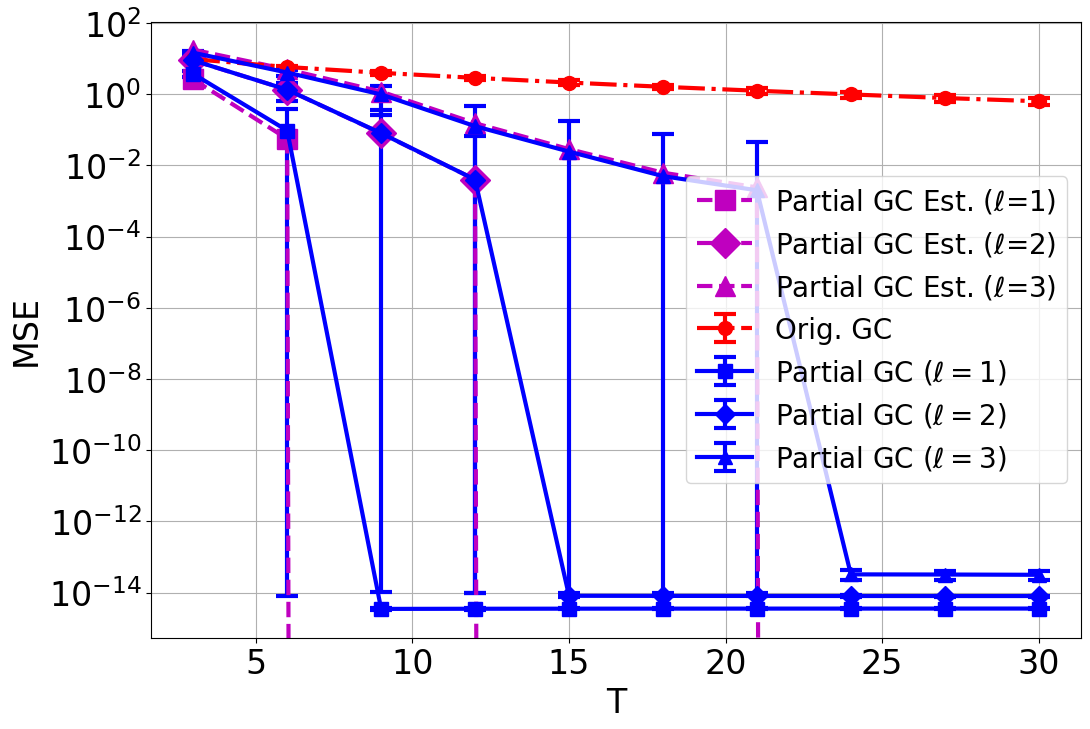

mean [3.72 0.0953 3.49e-15 3.53e-15 3.55e-15 3.56e-15 3.56e-15 3.57e-15 3.57e-15 3.57e-15]
std [0.677 0.299 1.79e-16 1.79e-16 1.8e-16 1.77e-16 1.76e-16 1.75e-16 1.78e-16 1.78e-16]
low_CI [1.27 0.0953 3.69e-16 3.61e-16 3.49e-16 3.68e-16 3.54e-16 3.57e-16 3.62e-16 3.57e-16]
high_CI [1.38 0.905 3.48e-16 3.7e-16 3.96e-16 3.63e-16 3.65e-16 3.5e-16 3.56e-16 3.5e-16]
mean [4.2 0.359 0.017 0.001 3.56e-15 3.56e-15 3.57e-15 3.57e-15 3.57e-15 3.57e-15]
std [0.704 0.523 0.129 0.0316 1.8e-16 1.84e-16 1.83e-16 1.79e-16 1.77e-16 1.78e-16]
low_CI [1.37 0.359 0.017 0.001 3.44e-16 3.48e-16 3.54e-16 3.73e-16 3.66e-16 3.76e-16]
high_CI [1.55 1.06 -0.017 -0.001 3.88e-16 4.08e-16 3.85e-16 3.65e-16 3.73e-16 3.45e-16]
mean [8.9 1.34 0.0803 0.004 8.16e-15 8.1e-15 8.07e-15 8.05e-15 8.03e-15 8.03e-15]
std [0.905 0.69 0.273 0.0631 4.51e-16 2.87e-16 2.76e-16 2.79e-16 2.76e-16 2.75e-16]
low_CI [1.97 1.34 0.0803 0.004 6.1e-16 5.53e-16 5.15e-16 5.07e-16 5.27e-16 5.54e-16]
high_CI [1.82 1.31 0.92 -0.004 6.8e-16 5.89e-

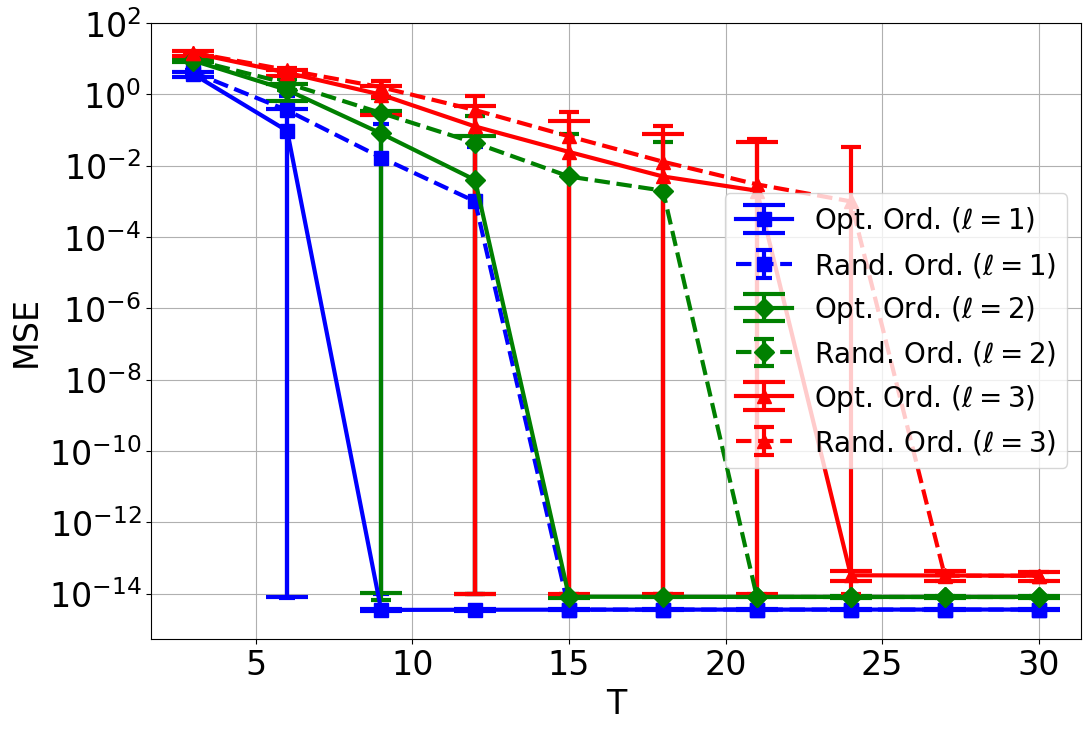

printing mean value of Q max over all orderings
Qmax l=1 ours 36.0
Qmax l=2 ours 35.0
Qmax l=3 ours 33.0
Qmax l=1 random 52.014
Qmax l=2 random 48.849
Qmax l=3 random 44.277
mean [11.8 7.11 4.88 3.51 2.61 1.97 1.51 1.16 0.912 0.723]
std [0.677 0.544 0.438 0.375 0.309 0.259 0.227 0.194 0.166 0.145]
low_CI [1.4 1.04 0.866 0.696 0.623 0.523 0.427 0.374 0.309 0.262]
high_CI [1.41 1.19 0.935 0.847 0.681 0.597 0.486 0.427 0.343 0.315]
T [ 3  6  9 12 15 18 21 24 27 30]
means_l_1_org_err [11.8 7.11 4.88 3.51 2.61 1.97 1.51 1.16 0.912 0.723]
mean [4.51 0.126 0.001 4.31e-15 4.34e-15 4.35e-15 4.36e-15 4.36e-15 4.37e-15 4.37e-15]
std [0.69 0.343 0.0316 1.73e-16 1.73e-16 1.75e-16 1.7e-16 1.77e-16 1.77e-16 1.76e-16]
low_CI [1.35 0.126 0.001 3.66e-16 3.44e-16 3.42e-16 3.42e-16 3.63e-16 3.69e-16 3.48e-16]
high_CI [1.41 0.874 -0.001 3.47e-16 3.62e-16 3.65e-16 3.48e-16 3.65e-16 3.5e-16 3.72e-16]
means_l_1_ours_err [4.51 0.126 0.001 4.31e-15 4.34e-15 4.35e-15 4.36e-15 4.36e-15 4.37e-15 4.37e-15]
mean [10

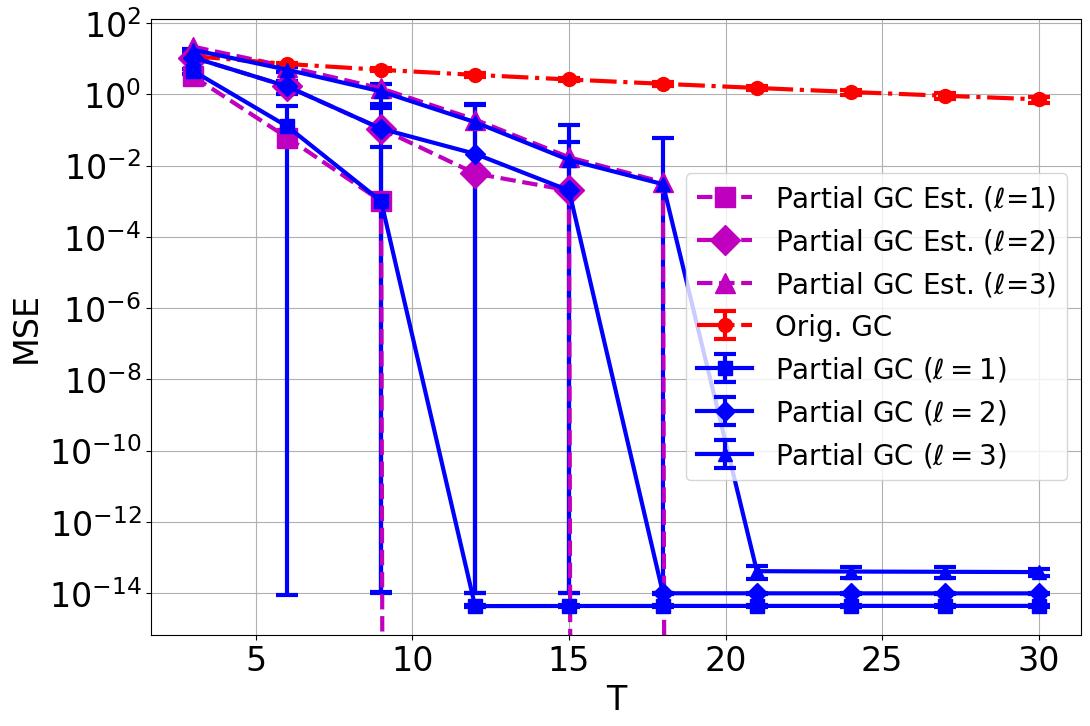

mean [4.51 0.126 0.001 4.31e-15 4.34e-15 4.35e-15 4.36e-15 4.36e-15 4.37e-15 4.37e-15]
std [0.69 0.343 0.0316 1.73e-16 1.73e-16 1.75e-16 1.7e-16 1.77e-16 1.77e-16 1.76e-16]
low_CI [1.35 0.126 0.001 3.66e-16 3.44e-16 3.42e-16 3.42e-16 3.63e-16 3.69e-16 3.48e-16]
high_CI [1.41 0.874 -0.001 3.47e-16 3.62e-16 3.65e-16 3.48e-16 3.65e-16 3.5e-16 3.72e-16]
mean [5.17 0.512 0.0251 0.002 4.34e-15 4.36e-15 4.37e-15 4.37e-15 4.38e-15 4.38e-15]
std [1.76 0.586 0.157 0.0447 1.79e-16 1.73e-16 1.76e-16 1.74e-16 1.83e-16 1.78e-16]
low_CI [1.43 0.512 0.0251 0.002 3.47e-16 3.27e-16 3.44e-16 3.36e-16 3.56e-16 3.44e-16]
high_CI [1.39 1.22 0.975 -0.002 3.76e-16 3.55e-16 3.8e-16 3.71e-16 3.91e-16 4.02e-16]
mean [10.8 1.67 0.108 0.0214 0.002 9.88e-15 9.85e-15 9.83e-15 9.82e-15 9.81e-15]
std [0.928 0.652 0.317 0.493 0.0447 2.8e-16 2.76e-16 2.79e-16 2.79e-16 2.74e-16]
low_CI [1.84 1.67 0.108 0.0214 0.002 5.44e-16 5.41e-16 5.23e-16 5.7e-16 5.38e-16]
high_CI [1.86 1.16 0.892 -0.0214 -0.002 6.59e-16 6.16e-16 6.1e

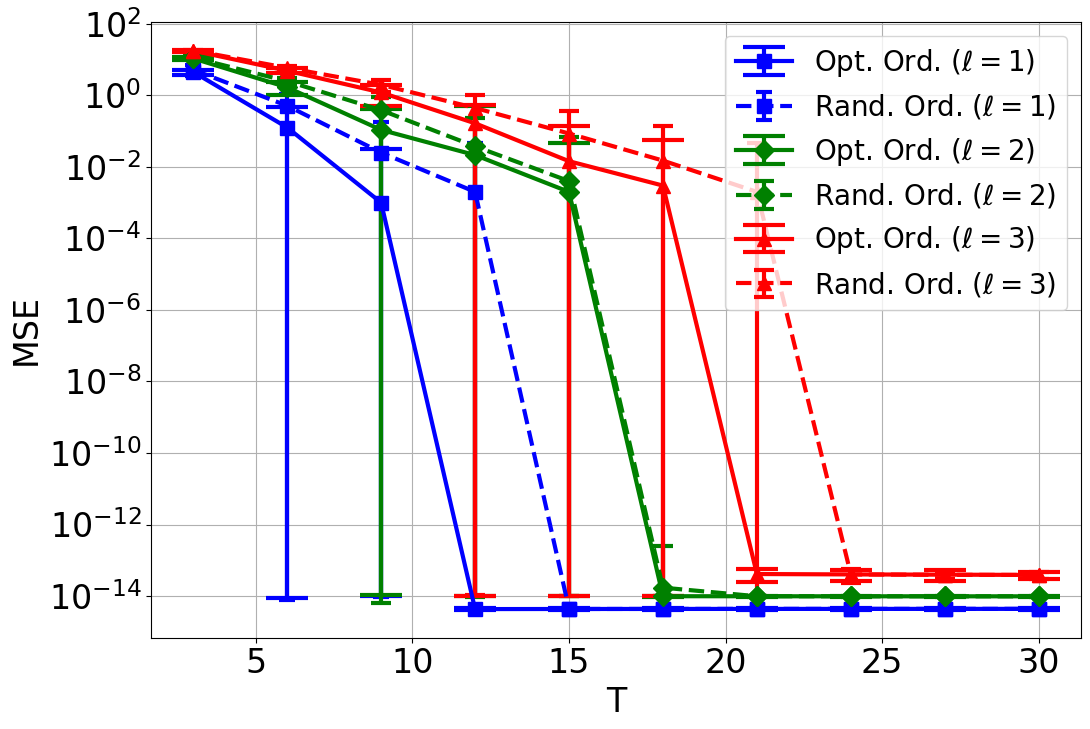

printing mean value of Q max over all orderings
Qmax l=1 ours 36.0
Qmax l=2 ours 35.0
Qmax l=3 ours 33.0
Qmax l=1 random 52.78
Qmax l=2 random 49.54
Qmax l=3 random 44.718


In [8]:
# Load the result
with open('experiment_result.pkl', 'rb') as file:
    data = pickle.load(file)
    #print(len(data))
    #print(data)
    # Plot results
    for i in range(len(data)):
        plot_result_ours_orig(data[i], name = "compare_ours_original_G" + str(int(i*100+200)))
        plot_result_ours_random(data[i], name = "compare_ours_random_G" + str(int(i*100+200)))

## Cell **5**

This cell performs the Exact GC simulation.


Running the exactGC simulation with different assignment matrices-
   - the first one is a cyclic assignment matrix
   - the second one is a graph assignment matrix

These are run for $\ell = 1,2,3$

The graph in the paper is generated by running this for $1000$ iterations

In [ ]:
with open('Adjacency_matrices.pkl', 'rb') as file:
    data1 = pickle.load(file)

cyclic_A = cyclic_assignment_matrix()
graph_assign_A = data1[0]

a1, b1, c1 = do_experiment2(cyclic_A, t = 50, l = 1, num_iter = 1000, print_progress = True, failure_worker = False)
a2, b2, c2 = do_experiment2(cyclic_A, t = 50, l = 2, num_iter = 1000, print_progress = True, failure_worker = False)
a3, b3, c3 = do_experiment2(cyclic_A, t = 50, l = 3, num_iter = 1000, print_progress = True, failure_worker = False)

# Storing results of the experiment in a pkl file, helps with reproducibility
with open('exact_gc_results_cyclic.pkl', 'wb') as file:
  pickle.dump({'a1': a1, 'a2': a2, 'a3': a3, 'b1': b1, 'b2': b2, 'b3': b3, 'c1': c1, 'c2': c2, 'c3': c3}, file)

In [ ]:
x1, y1, z1 = do_experiment2(graph_assign_A, t = 50, l = 1, num_iter = 1000, print_progress = True, failure_worker = False)
print("done")
with open('rand.pkl', 'wb') as file:
  pickle.dump({'x1': x1, 'y1': y1, 'z1': z1}, file)

In [ ]:
x2, y2, z2 = do_experiment2(graph_assign_A, t = 50, l = 2, num_iter = 1000, print_progress = True, failure_worker = False)
print("done")
with open('rand2.pkl', 'wb') as file:
    pickle.dump({'x2': x2, 'y2': y2, 'z2': z2}, file)


In [ ]:
x3, y3, z3 = do_experiment2(graph_assign_A, t = 50, l = 3, num_iter = 1000, print_progress = True, failure_worker = False)
print("done")
with open('rand3_2.pkl', 'wb') as file:
    pickle.dump({'x3': x3, 'y3': y3, 'z3': z3}, file)

## Cell **6**

This cell plots the result of Exact GC simulation with comparism between Partial GC and Original GC.

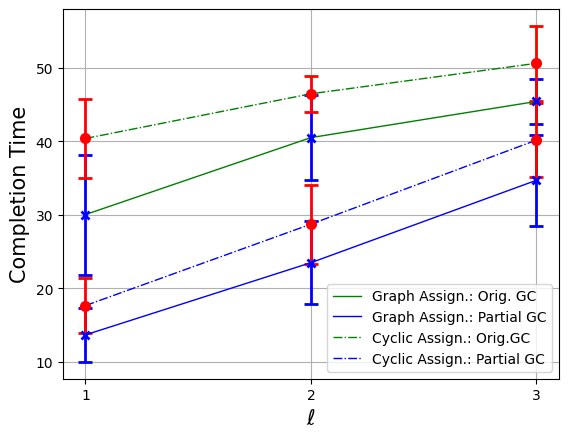

<Figure size 30000x30000 with 0 Axes>

[30.043203371970495, 40.520282186948855, 45.44444444444444]
[40.40117994100295, 46.48717948717949, 50.63737623762376]
[46, 47, 44, 42, 49, 48, 47, 44, 47, 44, 48, 46, 49, 46, 48, 49, 49, 40, 37, 45, 47, 44, 44, 35, 42, 48, 49, 47, 49, 42, 47, 49, 40, 47, 46, 46, 45, 44, 49, 46, 46, 46, 49, 49, 45, 47, 48, 46, 44, 49, 47, 45, 43, 46, 44, 47, 43, 42, 48, 42, 43, 47, 43, 39, 46, 47, 41, 46, 49, 37, 46, 46, 40, 45, 49, 45, 49, 46, 45, 46, 49]
[53, 58, 55, 43, 52, 57, 49, 49, 55, 49, 59, 43, 53, 58, 60, 49, 47, 55, 53, 54, 56, 55, 56, 45, 58, 55, 54, 53, 45, 48, 50, 51, 51, 53, 45, 59, 55, 53, 43, 51, 50, 59, 50, 54, 48, 45, 54, 56, 48, 53, 50, 46, 58, 53, 55, 45, 45, 51, 48, 59, 57, 52, 47, 57, 52, 59, 49, 51, 43, 53, 56, 39, 47, 50, 40, 37, 55, 54, 46, 48, 56, 50, 56, 47, 56, 55, 50, 50, 56, 54, 55, 49, 43, 41, 53, 45, 49, 56, 60, 49, 55, 53, 58, 53, 44, 54, 58, 49, 55, 43, 58, 49, 59, 40, 53, 43, 50, 47, 57, 46, 48, 38, 43, 54, 42, 46, 50, 55, 45, 44, 51, 49, 52, 57, 56, 55, 36, 51, 47, 

In [ ]:
# get the standard deviation and the mean of the arrays generated in the previous cell


std_1_org = np.std(a1)
std_1_ours = np.std(b1)
std_rand_1 = np.std(c1)
std_2_org = np.std(a2)
std_2_ours = np.std(b2)
std_rand_2 = np.std(c2)
std_3_org = np.std(a3)
std_3_ours = np.std(b3)
std_rand_3 = np.std(c3)


std_1_orgb = np.std(x1)
std_1_oursb = np.std(y1)
std_rand_1b = np.std(z1)
std_2_orgb = np.std(x2)
std_2_oursb = np.std(y2)
std_rand_2b = np.std(z2)
std_3_orgb = np.std(x3)
std_3_oursb = np.std(y3)
std_rand_3b = np.std(z3)

mean_1_org = np.mean(a1)
mean_1_ours = np.mean(b1)
mean_rand1 = np.mean(c1)
mean_2_org = np.mean(a2)
mean_2_ours = np.mean(b2)
mean_rand2 = np.mean(c2)
mean_3_org = np.mean(a3)
mean_3_ours = np.mean(b3)
mean_rand3 = np.mean(c3)

mean_1_orgb = np.mean(x1)
mean_1_oursb = np.mean(y1)
mean_rand1b = np.mean(z1)
mean_2_orgb = np.mean(x2)
mean_2_oursb = np.mean(y2)
mean_rand2b = np.mean(z2)
mean_3_orgb = np.mean(x3)
mean_3_oursb = np.mean(y3)
mean_rand3b = np.mean(z3)

plt.errorbar(1, mean_1_org, yerr=std_1_org, fmt='x', color='blue', capsize=5, elinewidth=2, markeredgewidth=2)
plt.errorbar(1, mean_1_ours, yerr=std_1_ours, fmt='x', color='blue', capsize=5, elinewidth=2, markeredgewidth=2)

plt.errorbar(2, mean_2_org, yerr=std_2_org, fmt='x', color='blue', capsize=5, elinewidth=2, markeredgewidth=2)
plt.errorbar(2, mean_2_ours, yerr=std_2_ours, fmt='x', color='blue', capsize=5, elinewidth=2, markeredgewidth=2)

plt.errorbar(3, mean_3_org, yerr=std_3_org, fmt='x', color='blue', capsize=5, elinewidth=2, markeredgewidth=2)
plt.errorbar(3, mean_3_ours, yerr=std_3_ours, fmt='x', color='blue', capsize=5, elinewidth=2, markeredgewidth=2)

plt.errorbar(1, mean_1_orgb, yerr=std_1_orgb, fmt='o', color='red', capsize=5, elinewidth=2, markeredgewidth=2)
plt.errorbar(1, mean_1_oursb, yerr=std_1_oursb, fmt='o', color='red', capsize=5, elinewidth=2, markeredgewidth=2)

plt.errorbar(2, mean_2_orgb, yerr=std_2_orgb, fmt='o', color='red', capsize=5, elinewidth=2, markeredgewidth=2)
plt.errorbar(2, mean_2_oursb, yerr=std_2_oursb, fmt='o', color='red', capsize=5, elinewidth=2, markeredgewidth=2)

plt.errorbar(3, mean_3_orgb, yerr=std_3_orgb, fmt='o', color='red', capsize=5, elinewidth=2, markeredgewidth=2)
plt.errorbar(3, mean_3_oursb, yerr=std_3_oursb, fmt='o', color='red', capsize=5, elinewidth=2, markeredgewidth=2)

# Set labels and title
plt.xlabel('$\ell$',  fontsize=15)
plt.ylabel('Completion Time',  fontsize=15)
plt.legend()
plt.plot([1, 2, 3], [mean_1_org, mean_2_org, mean_3_org], color='green', linestyle='-', linewidth=1, label="Graph Assign.: Orig. GC")
plt.plot([1, 2, 3], [mean_1_ours, mean_2_ours, mean_3_ours], color='blue', linestyle='-', linewidth=1, label = "Graph Assign.: Partial GC")

plt.plot([1, 2, 3], [mean_1_orgb, mean_2_orgb, mean_3_orgb], color='green', linestyle='dashdot', linewidth=1,  label="Cyclic Assign.: Orig.GC")
plt.plot([1, 2, 3], [mean_1_oursb, mean_2_oursb, mean_3_oursb], color='blue', linestyle='dashdot', linewidth=1,  label="Cyclic Assign.: Partial GC")

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

#plt.xaxis.set_major_locator(MaxNLocator(integer=True))
# Show plot

plt.legend()

plt.grid(True)
plt.figure(figsize=(300, 300))
plt.show()
print([mean_1_org, mean_2_org, mean_3_org])
print([mean_1_orgb, mean_2_orgb, mean_3_orgb])
print(a3)
print(x3)

## Cell **7**

This cell plots the result of Exact GC simulation with comparism between Opt. Ord. and Rand. Ord. We have generated 100 of rand ordering, pick best and then do 1000 simulations to get each point.

error bars: 1 standard deviation

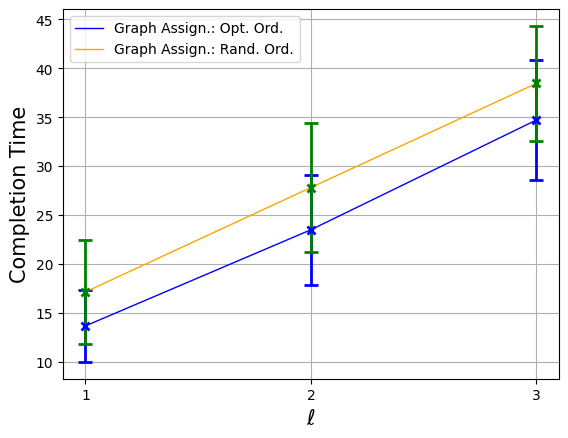

<Figure size 30000x30000 with 0 Axes>

In [ ]:
plt.errorbar(1, mean_1_ours, yerr=std_1_ours, fmt='x', color='blue', capsize=5, elinewidth=2, markeredgewidth=2)
plt.errorbar(1, mean_rand1, yerr=std_rand_1, fmt='x', color='green', capsize=5, elinewidth=2, markeredgewidth=2)

plt.errorbar(2, mean_2_ours, yerr=std_2_ours, fmt='x', color='blue', capsize=5, elinewidth=2, markeredgewidth=2)
plt.errorbar(2, mean_rand2, yerr=std_rand_2, fmt='x', color='green', capsize=5, elinewidth=2, markeredgewidth=2)

plt.errorbar(3, mean_3_ours, yerr=std_3_ours, fmt='x', color='blue', capsize=5, elinewidth=2, markeredgewidth=2)
plt.errorbar(3, mean_rand3, yerr=std_rand_3, fmt='x', color='green', capsize=5, elinewidth=2, markeredgewidth=2)

# Set labels and title
plt.xlabel('$\ell$',  fontsize=15)
plt.ylabel('Completion Time',  fontsize=15)
plt.legend()
plt.plot([1, 2, 3], [mean_1_ours, mean_2_ours, mean_3_ours], color='blue', linestyle='-', linewidth=1, label = "Graph Assign.: Opt. Ord.")
plt.plot([1, 2, 3], [mean_rand1, mean_rand2, mean_rand3], color='orange', linestyle='-', linewidth=1, label="Graph Assign.: Rand. Ord.")

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

#plt.xaxis.set_major_locator(MaxNLocator(integer=True))
# Show plot

plt.legend()

plt.grid(True)
plt.figure(figsize=(300, 300))
plt.show()